In [1]:
from ipyimports import *


def rayleightest(data, axis=None, weights=None):
    """ Performs the Rayleigh test of uniformity.

    This test is  used to identify a non-uniform distribution, i.e. it is
    designed for detecting an unimodal deviation from uniformity. More
    precisely, it assumes the following hypotheses:
    - H0 (null hypothesis): The population is distributed uniformly around the
    circle.
    - H1 (alternative hypothesis): The population is not distributed uniformly
    around the circle.
    Small p-values suggest to reject the null hypothesis.

    Parameters
    ----------
    data : numpy.ndarray or Quantity
        Array of circular (directional) data, which is assumed to be in
        radians whenever ``data`` is ``numpy.ndarray``.
    axis : int, optional
        Axis along which the Rayleigh test will be performed.
    weights : numpy.ndarray, optional
        In case of grouped data, the i-th element of ``weights`` represents a
        weighting factor for each group such that ``np.sum(weights, axis)``
        equals the number of observations.
        See [1]_, remark 1.4, page 22, for detailed explanation.

    Returns
    -------
    p-value : float or dimensionless Quantity
        p-value.

    Examples
    --------
    >>> import numpy as np
    >>> from astropy.stats import rayleightest
    >>> from astropy import units as u
    >>> data = np.array([130, 90, 0, 145])*u.deg
    >>> rayleightest(data) # doctest: +FLOAT_CMP
    <Quantity 0.2563487733797317>

    References
    ----------
    .. [1] S. R. Jammalamadaka, A. SenGupta. "Topics in Circular Statistics".
       Series on Multivariate Analysis, Vol. 5, 2001.
    .. [2] C. Agostinelli, U. Lund. "Circular Statistics from 'Topics in
       Circular Statistics (2001)'". 2015.
       <https://cran.r-project.org/web/packages/CircStats/CircStats.pdf>
    .. [3] M. Chirstman., C. Miller. "Testing a Sample of Directions for
       Uniformity." Lecture Notes, STA 6934/5805. University of Florida, 2007.
    .. [4] D. Wilkie. "Rayleigh Test for Randomness of Circular Data". Applied
       Statistics. 1983.
       <http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.211.4762>
    """
    
    def _length(data, p=1, phi=0.0, axis=None, weights=None):
        # Utility function for computing the generalized sample length
        C, S = _components(data, p, phi, axis, weights)
        return np.hypot(S, C)


    def _components(data, p=1, phi=0.0, axis=None, weights=None):
        # Utility function for computing the generalized rectangular components
        # of the circular data.
        if weights is None:
            weights = np.ones((1,))
        try:
            weights = np.broadcast_to(weights, data.shape)
        except ValueError:
            raise ValueError('Weights and data have inconsistent shape.')

        C = np.sum(weights * np.cos(p * (data - phi)), axis)/np.sum(weights, axis)
        S = np.sum(weights * np.sin(p * (data - phi)), axis)/np.sum(weights, axis)

        return C, S
    n = np.size(data, axis=axis)
    Rbar = _length(data, 1, 0.0, axis, weights)
    z = n*Rbar*Rbar

    # see [3] and [4] for the formulae below
    tmp = 1.0
    if(n < 50):
        tmp = 1.0 + (2.0*z - z*z)/(4.0*n) - (24.0*z - 132.0*z**2.0 +
                                             76.0*z**3.0 - 9.0*z**4.0)/(288.0 *
                                                                        n * n)

    p_value = np.exp(-z)*tmp
    return p_value

def getCircularMean(angles):
    n = len(angles)
    sineMean = np.divide(np.sum(np.sin(np.radians(angles))), n)
    cosineMean = np.divide(np.sum(np.cos(np.radians(angles))), n)
    vectorMean = np.arctan2(sineMean, cosineMean)
    r=np.sqrt(np.square(sineMean)+np.square(cosineMean))
    return np.degrees(vectorMean),r

In [2]:
def polarHist(df,ax=None,bins=40,bottom = 0,kind='bar',fname='',start=100,stepSize=40,alpha=0.6,s=50,toShow=True):
       
        
    r,t=np.histogram((df.trajectory__pOri_x%360),bins=bins,density=False)
#     r=r/float(max(r))
    width =(2*np.pi) / len(r)
    
    t=np.deg2rad(t[:-1])

    if ax is None:
        ax = plt.subplot(111, polar=True)
        
    if kind=='outline':
        bars = ax.plot(t, r)
    elif kind=='scatterStack':
        #initialize empty arrays
        i=0
        tl=np.array([])
        rl=np.array([])

        for the in t:
            currRl=range(start,r[i]+start,stepSize)
            currTl=np.repeat(the,len(currRl))
            rl=np.append(rl,currRl)
            tl=np.append(tl,currTl)
            i+=1
       
        ax.scatter((tl), rl,alpha=alpha,s=s)
#         ax.set_theta_zero_location("N")
        ax.set_theta_offset(np.pi/2)
        
    else:# 'mostly standard bar'
        bars = ax.bar(t, r, width=width, bottom=bottom)
        
        
    tor=df.trajectory__wbad.abs().mean()
    pval=rayleightest(np.deg2rad(df.trajectory__pOri_x[::100]))
    meanAng, angDisp=getCircularMean(df.trajectory__pOri_x)
    
    ax.arrow(0,0,np.deg2rad(meanAng%360),angDisp*max(r),lw=3,)# shape='full',
             #length_includes_head=True, head_width=100)

    
    tit='Mean Angle : '+str(round(meanAng,1))+ '\nAngular Dispersion : '+\
        str(round(angDisp,4))+'\nP-value : '+str(pval)
    ax.set_title(tit)
    print pval
#     ax.set_title('tortuosity is'+str(round(tor,3)))

#     ax.autoscale()
#     figFname=fname.split('pickle')[0]+'polarHist.png'
#     plt.savefig(figFname,transparency=True)
    
    if toShow:
        plt.show()    
    else:
        plt.close()


    return r,t,ax







def polarPitoo(df,kmaxAngle=15,initRadius=0,radIncrement=1./165, c='r', s=10, alpha=0.05,):
    initH=df.trajectory__pOri_x[0]
    r=initRadius
    radius=[]
    theta=[]

    for i in range(len(df)):
        currH=df.trajectory__pOri_x[i]
        
        if abs(currH-initH)>maxAngle:
            initH=df.trajectory__pOri_x[i]
            r=initRadius
        else:
            r+=radIncrement

        t=np.deg2rad(currH)
        radius.append(r)
        theta.append(t)

    
    if ax is None:
        ax = plt.subplot(111, projection='polar')
        
    # c = ax.scatter(theta, r, c='r', s=10, cmap='hsv', alpha=0.75)
    c = ax.scatter(theta, radius, c=c, s=s, alpha=alpha)


    plt.show()
    
    return radius,theta, c


def quadPolarHist(df=None,bins=40,bottom = 0,kind='bar',fname='',
                  toShow=True,start=100,stepSize=40,alpha=0.6,s=50):
    
    if df is None:
        dfDump=pickle2df()
        df=dfDump[0]
        fname=dfDump[-1]
        
    #make a empty polar fig
    f, axarr = plt.subplots(2, 2, subplot_kw=dict(projection='polar'),figsize=(10,12))
    
    #polar plots as quad
    d=polarHist(df[(df.trajectory__case==0) & (df.trajectory__headingControl)],
              ax=axarr[0,1],bins=bins,bottom = bottom,kind=kind,start=start,
              stepSize=stepSize,alpha=alpha,s=s,toShow=toShow)
    d=polarHist(df[(df.trajectory__case==1) & (df.trajectory__headingControl)],
              ax=axarr[0,0],bins=bins,bottom = bottom,kind=kind,start=start,
              stepSize=stepSize,alpha=alpha,s=s,toShow=toShow)
    d=polarHist(df[(df.trajectory__case==2) & (df.trajectory__headingControl)],
              ax=axarr[1,0],bins=bins,bottom = bottom,kind=kind,start=start,
              stepSize=stepSize,alpha=alpha,s=s,toShow=toShow)
    d=polarHist(df[(df.trajectory__case==3) & (df.trajectory__headingControl)],
              ax=axarr[1,1],bins=bins,bottom = bottom,kind=kind,start=start,
              stepSize=stepSize,alpha=alpha,s=s,toShow=toShow)
    
    #set lims on min/max
    ylims=[]
    for row,col in axarr:
        ylims.append(row.get_ylim()[1])
        ylims.append(col.get_ylim()[1])
    yMax=max(ylims)
    yMin=0
    for row,col in axarr:
        row.set_ylim(yMin,yMax)
        col.set_ylim(yMin,yMax)

    figFname=fname.split('pickle')[0]+kind+'polarHist.png'
    f.suptitle(fname.split('/')[-1], fontsize=12)
    plt.savefig(figFname,transparency=True,dpi=300)
    if toShow:
        plt.show()
    else:
        plt.close()
    
    return axarr
    
def pickleDir2Polar(foldPath=None,bins=40,bottom = 0,kind='bar',toShow=True,
                    start=100,stepSize=40,alpha=0.6,s=50):
    
    filenames=fileList(foldPath=foldPath)
    
    for filename in filenames:
        dfDump=pickle2df(path=filename)
        df=dfDump[0]
        fname=dfDump[-1]
        
        a=quadPolarHist(df,bins,bottom,kind,fname,toShow)
        plt.close()


In [2]:
%matplotlib notebook


In [4]:
tic()
dfl2={}
for i, filepath in enumerate( a):
#     df=pickle2df(filepath)[0]
    try:
        df=pd.read_hdf('.'.join(filepath.split('.')[0:-1])+'.h5')
        fnjson='.'.join(a[0].split('.')[:-2])+'.json'
        with open(fnjson) as f:
            parameters=json.load(f)
        df.parameters=parameters['parameters']
        timestamp='_'.join(filepath.split('/')[-1].split('_')[:3])
        dfl2[timestamp]=df
            
#         dfl2.append(df)
    except IOError:
        print ('some io error at'), filepath
    print "Reading file {0} of {1}".format(i,len(a))
toc()    
b=pd.concat(dfl2)

Reading file 0 of 43
Reading file 1 of 43
Reading file 2 of 43
Reading file 3 of 43
Reading file 4 of 43
Reading file 5 of 43
Reading file 6 of 43
Reading file 7 of 43
Reading file 8 of 43
Reading file 9 of 43
Reading file 10 of 43
Reading file 11 of 43
Reading file 12 of 43
Reading file 13 of 43
Reading file 14 of 43
Reading file 15 of 43
Reading file 16 of 43
Reading file 17 of 43
Reading file 18 of 43
Reading file 19 of 43
Reading file 20 of 43
Reading file 21 of 43
Reading file 22 of 43
Reading file 23 of 43
Reading file 24 of 43
Reading file 25 of 43
Reading file 26 of 43
Reading file 27 of 43
Reading file 28 of 43
Reading file 29 of 43
Reading file 30 of 43
Reading file 31 of 43
Reading file 32 of 43
Reading file 33 of 43
Reading file 34 of 43
Reading file 35 of 43
Reading file 36 of 43
Reading file 37 of 43
Reading file 38 of 43
Reading file 39 of 43
Reading file 40 of 43
Reading file 41 of 43
Reading file 42 of 43
Elapsed time: 0.855794 seconds.



In [5]:
pickle2bokeh(hdf5=True)

KeyError: 'windQuadOpen'

In [4]:
a=fileList(defDir='/media/rhagoletis/Traj/')


In [3]:
filepath=easygui.fileopenbox()
df=pd.read_hdf('.'.join(filepath.split('.')[0:-1])+'.h5')


AttributeError: 'NoneType' object has no attribute 'split'

In [5]:
tic()
dfl2=[]
for i, filepath in enumerate( a):
#     df=pickle2df(filepath)[0]
    try:
        df=pd.read_hdf('.'.join(filepath.split('.')[0:-1])+'.h5')
        fnjson='.'.join(a[0].split('.')[:-2])+'.json'
        with open(fnjson) as f:
            parameters=json.load(f)
        df.parameters=parameters['parameters']
        
        windPressure=filepath.split('/')[-2:-1][0]
        visual=filepath.split('/')[-4:-3][0]
        flowSource=filepath.split('/')[-3:-2][0]
        timestamp='_'.join(filepath.split('/')[-1].split('_')[:3])
        
        df['windPressure']=windPressure
        df['visual']=visual
        df['flowSource']=flowSource
        df['timeStamp']=timestamp
        
        dfl2.append(df)
            
#         dfl2.append(df)
    except IOError:
        print ('some io error at'), filepath
#     print "Reading file {0} of {1}".format(i,len(a))
    print(parameters['parameters']['windQuadOpen'])
    
toc()    
b=pd.concat(dfl2)

[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
[90, 0, 90, 180]
Elapsed time: 7.525410 seconds.



In [6]:
for i in b.windPressure.unique():
    bokehQuadPlot(b[b['windPressure']==i],parameters['parameters'],showPlot=True)

KeyboardInterrupt: 

In [6]:
df1=b[b['timeStamp']=='2018-01-17__14~38~15']

In [7]:
coll=[]
def fitter(arr):
    try :
        a= (np.polyfit(arr,np.arange(len(arr)),1))
        coll.append(a)
        return a[0]

    except ValueError:
        return np.NaN
    
    

In [77]:
def fitter(arr):
    if np.sum(np.isnan(arr))>0:
        return 0
    else:
        return (np.polyfit(arr.values,np.arange(len(arr)),1))[0]
def dumbMean(arr):
    return np.mean(arr)

def printer(arr):
    try :
#         print (np.polyfit(arr,np.arange(len(arr)),1))[0]
        a= (np.polyfit(arr,np.arange(len(arr)),1))

        return a[0]

    except ValueError:
#         print "hello"
        return -1

In [17]:
from scipy.stats import linregress

In [23]:
def fitter2(arr):
    try:
        slope,intercept,r,p,stderr=linregress(arr,np.arange(len(arr)))
        coll.append([slope,r**2])
        return slope
    except ValueError:
        return np.Nan

In [26]:

df1['slope']=df1.trajectory__pOri_x.rolling(100).apply(fitter)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [36]:
fits.reset_index(drop=True)

,slope,r
0,NaN,0.000000e+00
1,NaN,0.000000e+00
2,NaN,0.000000e+00
3,NaN,0.000000e+00
4,NaN,0.000000e+00
5,NaN,0.000000e+00
6,NaN,0.000000e+00
7,NaN,0.000000e+00
8,NaN,0.000000e+00
9,NaN,0.000000e+00


In [38]:
df1

,trajectory__DCoffset,trajectory__boutFrame,trajectory__case,trajectory__compensation,trajectory__gain,trajectory__groundSpeed,trajectory__headingControl,trajectory__impose,trajectory__imposeHeading,trajectory__imposeResponse,...,trajectory__valve1,trajectory__valve2,trajectory__valve3,trajectory__wbad,trajectory__wbas,windPressure,visual,flowSource,timeStamp,slope
2018-01-17 09:08:18.538726144,-0.02,0.0,0.0,0.0,8.0,432.812959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.112766,1.906645,0.,grassSky,direct,2018-01-17__14~38~15,NaN
2018-01-17 09:08:18.542435840,-0.02,0.0,0.0,0.0,8.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.112766,1.906645,0.,grassSky,direct,2018-01-17__14~38~15,NaN
2018-01-17 09:08:18.547606016,-0.02,0.0,0.0,0.0,8.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.112766,1.906645,0.,grassSky,direct,2018-01-17__14~38~15,NaN
2018-01-17 09:08:18.553721856,-0.02,0.0,0.0,0.0,8.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.112766,1.982512,0.,grassSky,direct,2018-01-17__14~38~15,NaN
2018-01-17 09:08:18.559709184,-0.02,0.0,0.0,0.0,8.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.112766,1.982512,0.,grassSky,direct,2018-01-17__14~38~15,NaN
2018-01-17 09:08:18.566168064,-0.02,0.0,0.0,0.0,8.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.093800,1.925612,0.,grassSky,direct,2018-01-17__14~38~15,NaN
2018-01-17 09:08:18.572449024,-0.02,0.0,0.0,0.0,8.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.416233,2.210111,0.,grassSky,direct,2018-01-17__14~38~15,NaN
2018-01-17 09:08:18.578305024,-0.02,0.0,0.0,0.0,8.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.416233,2.210111,0.,grassSky,direct,2018-01-17__14~38~15,NaN
2018-01-17 09:08:18.584527872,-0.02,0.0,0.0,0.0,8.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.169666,2.039412,0.,grassSky,direct,2018-01-17__14~38~15,NaN
2018-01-17 09:08:18.590462976,-0.02,0.0,0.0,0.0,8.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.169666,2.039412,0.,grassSky,direct,2018-01-17__14~38~15,NaN


In [40]:
pd.concat([df1,fits.reset_index(drop=True)],axis=1)

AttributeError: 'Index' object has no attribute 'freq'

In [28]:
coll=[]

df1.trajectory__pOri_x.rolling(10).apply(fitter2)
fits=pd.DataFrame(coll)
fits.columns=['slope','r']
fits

,slope,r
0,NaN,0.000000e+00
1,NaN,0.000000e+00
2,NaN,0.000000e+00
3,NaN,0.000000e+00
4,NaN,0.000000e+00
5,NaN,0.000000e+00
6,NaN,0.000000e+00
7,NaN,0.000000e+00
8,NaN,0.000000e+00
9,NaN,0.000000e+00


<IPython.core.display.Javascript object>


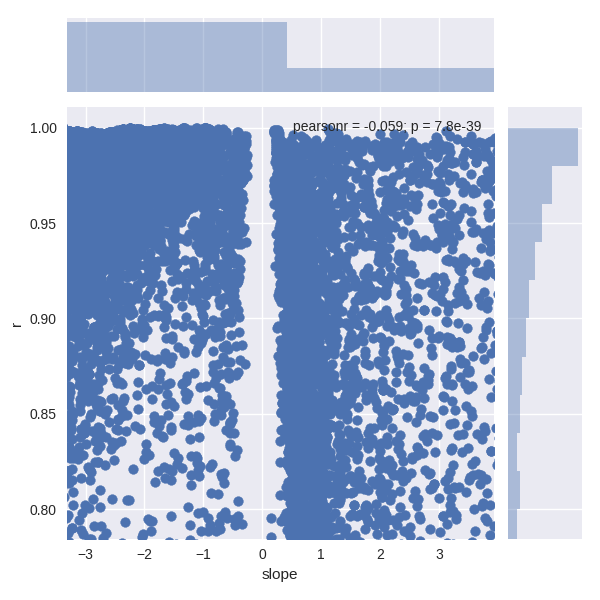

In [25]:
sns.jointplot('slope','r',data=fits)

<IPython.core.display.Javascript object>


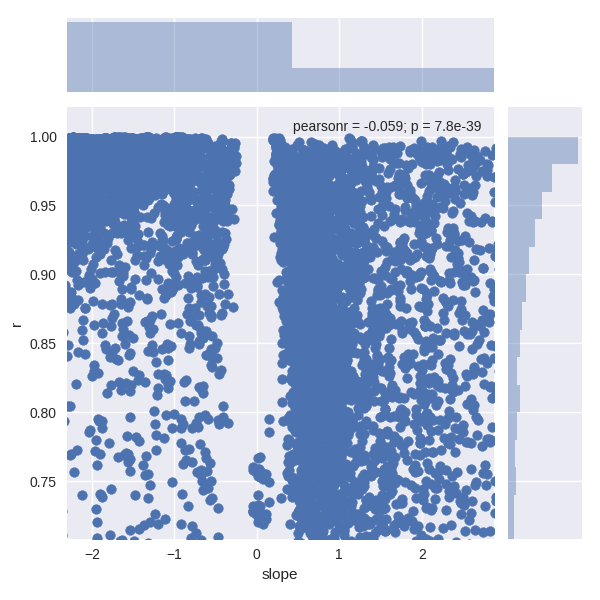

In [29]:
sns.jointplot('slope','r',data=fits)

<IPython.core.display.Javascript object>


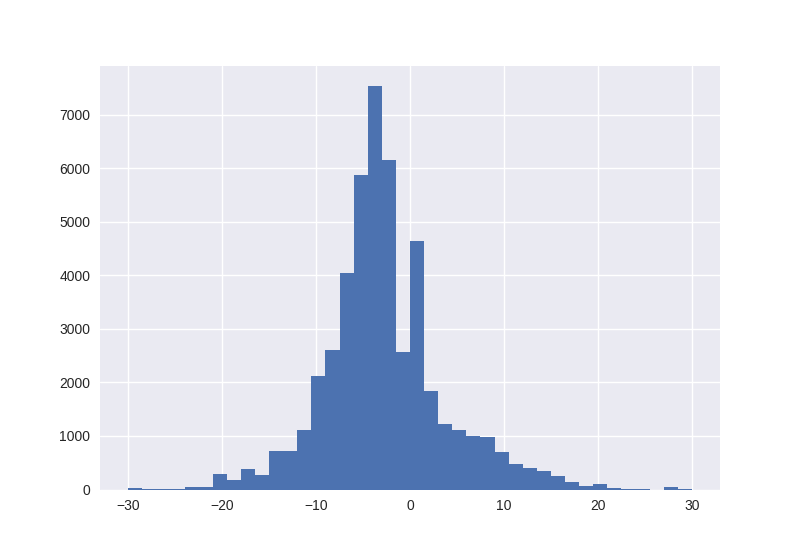

(array([2.300e+01, 7.000e+00, 1.300e+01, 1.800e+01, 3.800e+01, 4.900e+01,
        2.940e+02, 1.740e+02, 3.830e+02, 2.760e+02, 7.150e+02, 7.280e+02,
        1.111e+03, 2.124e+03, 2.599e+03, 4.041e+03, 5.879e+03, 7.532e+03,
        6.156e+03, 2.575e+03, 4.642e+03, 1.832e+03, 1.226e+03, 1.108e+03,
        9.970e+02, 9.810e+02, 7.060e+02, 4.800e+02, 4.060e+02, 3.380e+02,
        2.450e+02, 1.330e+02, 7.300e+01, 9.400e+01, 3.100e+01, 1.800e+01,
        1.000e+01, 0.000e+00, 5.600e+01, 2.000e+00]),
 array([-30. , -28.5, -27. , -25.5, -24. , -22.5, -21. , -19.5, -18. ,
        -16.5, -15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,
         -3. ,  -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,
         10.5,  12. ,  13.5,  15. ,  16.5,  18. ,  19.5,  21. ,  22.5,
         24. ,  25.5,  27. ,  28.5,  30. ]),
 <a list of 40 Patch objects>)

In [22]:
plt.hist(df1.slope,range=(-30,30),bins=40)

<IPython.core.display.Javascript object>


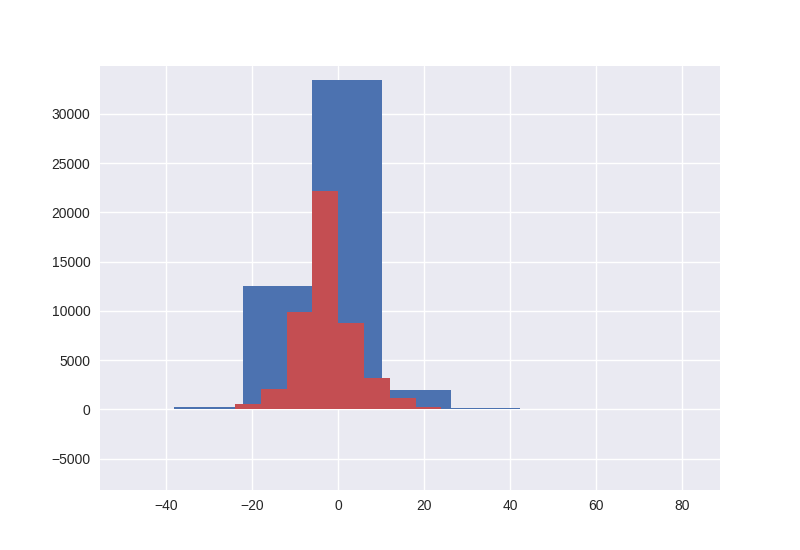

In [11]:
df1.slope.hist(bins=40)

In [ ]:
(df1.trajectory__pOri_x.rolling(100).mean()+200).plot(color='red')
df1.trajectory__pOri_x.plot()

<IPython.core.display.Javascript object>


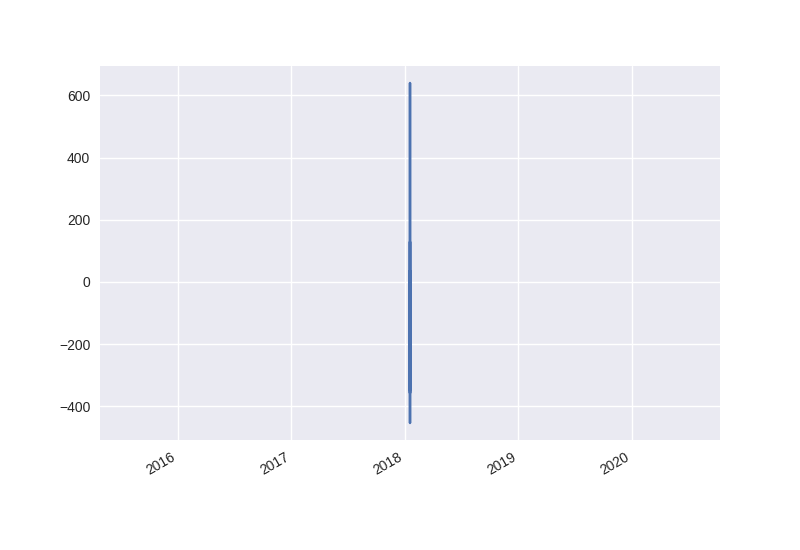

In [18]:
plt.scatter(df1.trajectory__pPos_x,df1.trajectory__pPos_y,s=2)
plt.axes().set_aspect('equal','datalim')

<IPython.core.display.Javascript object>


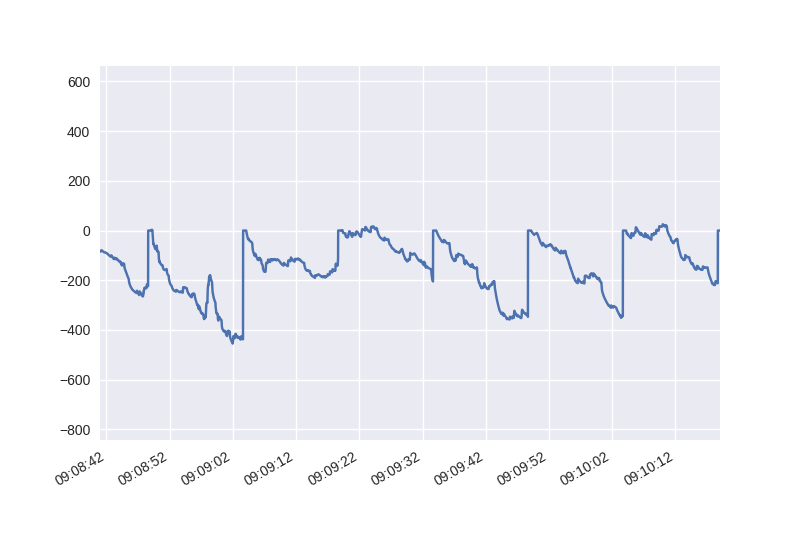

In [14]:
df1.trajectory__pOri_x.plot()

In [13]:
%matplotlib notebook


In [206]:
b.to_hdf('all_wind.h5','df')

In [176]:
parameters['parameters']['playerInitPos']

[513, 513, 1.3]

In [198]:
bokehQuadPlot(df,parameters['parameters'],showPlot=True)

(Column(id='a7378725-a90b-4194-b2b3-2d724323964a', ...),
 None,
 None,
 None,
 None)

In [8]:
from analFunc import *

In [194]:
for j in b.flowSource.unique():
    for i in b.windPressure.unique():
        bokehPlotRotateTraj(b[(b['windPressure']==i)&(b['flowSource']==j)],parameters,title='/media/rhagoletis/Traj/aggreg/wind/'+j+'_speed_'+str(i))

In [ ]:
for i in b.windPressure.unique():
    bokehPlotRotateTraj(b[b['windPressure']==i],parameters['parameters'],showPlot=True)
# bokehPlotRotateTraj(b[b['windPressure']==i],parameters)

In [199]:
bagDir2bokeh()

['/home/rhagoletis/catkin/src/World/bags/2018_06_09/2018-06-09__13~48~00_haw86_01_gain~8_speed~1.0_bout~15_DC~0.0_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_06/2018-06-06__13~38~03_apple85_00_wind_gain~8_speed~1.0_bout~15_DC~0.0_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_06/2018-06-06__13~23~26_apple85_00_wind_nullSky_nullGrass_gain~8_speed~1.0_bout~15_DC~0.0_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_06/2018-06-06__13~10~52_apple85_00_wind_nullSky_nullGrass_gain~8_speed~1.0_bout~15_DC~0.0_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_06/2018-06-06__13~01~15_apple85_01_gain~8_speed~1.0_bout~15_DC~0.0_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_02/2018-06-02__20~02~14_haw84_00_odour_wind_gain~8_speed~1.0_bout~20_DC~-0.05_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_02/2018-06-02__19~49~20_haw84_00_odour_gain~8_speed~1.0_bout~20_DC~-0.05_traj.bag', '/home/rhagoletis/catkin/src/World/bags/2018_06_02/

In [203]:
df.ix[::1000]

,trajectory__DCoffset,trajectory__boutFrame,trajectory__case,trajectory__compensation,trajectory__gain,trajectory__groundSpeed,trajectory__headingControl,trajectory__impose,trajectory__imposeHeading,trajectory__imposeResponse,...,trajectory__trial,trajectory__valve1,trajectory__valve2,trajectory__valve3,trajectory__wbad,trajectory__wbas,windPressure,visual,flowSource,timeStamp
2018-03-30 09:03:24.661211904,2.081668e-17,0.0,0.0,0.0,8.0,102.133538,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.322702e-01,1.934755,4.,null,valve,2018-03-30__14~33~21
2018-03-30 09:03:30.760203008,2.081668e-17,0.0,0.0,0.0,8.0,1.004307,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,5.933396e-02,1.733019,4.,null,valve,2018-03-30__14~33~21
2018-03-30 09:03:36.833345792,2.081668e-17,0.0,0.0,0.0,8.0,1.003145,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.373358e-02,1.768620,4.,null,valve,2018-03-30__14~33~21
2018-03-30 09:03:42.894433024,2.081668e-17,0.0,1.0,0.0,8.0,1.001678,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.068011e-01,1.875421,4.,null,valve,2018-03-30__14~33~21
2018-03-30 09:03:48.955461888,2.081668e-17,0.0,1.0,0.0,8.0,1.000614,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,9.493434e-02,1.816087,4.,null,valve,2018-03-30__14~33~21
2018-03-30 09:03:55.016537856,2.081668e-17,0.0,2.0,0.0,8.0,0.000000,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,3.560038e-02,1.851687,4.,null,valve,2018-03-30__14~33~21
2018-03-30 09:04:01.077734912,2.081668e-17,0.0,2.0,0.0,8.0,1.003499,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,1.186679e-02,1.922888,4.,null,valve,2018-03-30__14~33~21
2018-03-30 09:04:07.138891008,2.081668e-17,0.0,2.0,0.0,8.0,1.001247,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,2.610694e-01,1.863554,4.,null,valve,2018-03-30__14~33~21
2018-03-30 09:04:13.200314880,2.081668e-17,0.0,3.0,0.0,8.0,0.999498,1.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.746717e-02,1.958488,4.,null,valve,2018-03-30__14~33~21
2018-03-30 09:04:19.261219072,2.081668e-17,0.0,3.0,0.0,8.0,1.001070,1.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,3.560038e-02,1.994089,4.,null,valve,2018-03-30__14~33~21


In [197]:
bokehPlotRotateTraj(df.ix[::100],parameters)

In [195]:
def bokehPlotRotateTraj(df,parameters,title=''):
    output_file(title + ".html", title="Trajectory Quad", mode="cdn")

    br1 =bokehPlot(df=rotateTrajDF(df,90), case=1, parameters=parameters['parameters'], fig=None,
                  TOOLS="pan,crosshair,wheel_zoom\
                  ,box_zoom,reset,box_select,lasso_select,undo,redo,save",
                  x_range=(500, 526), y_range=(500, 526),
                  output_backend="webgl", plot_width=500, plot_height=500,
                  s=4, title='', addOdour=True,
                  addSmallTit=True, addStart=True, addArrow=False,
                  xw=20, yw=20, xi=506., yi=503.,showPlot=True,
                  reallign=False,xc=513, yc=513,decimation=10

                 )

    br1 =bokehPlot(df=rotateTrajDF(df,0), case=2, parameters=parameters['parameters'], fig=br1,
                  TOOLS="pan,crosshair,wheel_zoom\
                  ,box_zoom,reset,box_select,lasso_select,undo,redo,save",
                  x_range=(500, 526), y_range=(500, 526),
                  output_backend="webgl", plot_width=500, plot_height=500,
                  s=4, title='', addOdour=True,
                  addSmallTit=True, addStart=True, addArrow=False,
                  xw=20, yw=20, xi=506., yi=503.,showPlot=True,
                  reallign=False,xc=513, yc=513,decimation=10

                 )

    br1 =bokehPlot(df=rotateTrajDF(df,-90), case=3, parameters=parameters['parameters'], fig=br1,
                  TOOLS="pan,crosshair,wheel_zoom\
                  ,box_zoom,reset,box_select,lasso_select,undo,redo,save",
                  x_range=(500, 526), y_range=(500, 526),
                  output_backend="webgl", plot_width=500, plot_height=500,
                  s=4, title='', addOdour=True,
                  addSmallTit=True, addStart=True, addArrow=False,
                  xw=20, yw=20, xi=506., yi=503.,showPlot=True,
                  reallign=False,xc=513, yc=513,decimation=10

                 )
    
    br2=gridplot([[br1]])
    br2 = column(Div(text=title), br2)
    show(br2)


In [182]:
output_file('path' + ".html", title="Trajectory Quad", mode="cdn")

br1 =bokehPlot(df=rotateTrajDF(df,90), case=1, parameters=parameters['parameters'], fig=None,
              TOOLS="pan,crosshair,wheel_zoom\
              ,box_zoom,reset,box_select,lasso_select,undo,redo,save",
              x_range=(506, 526), y_range=(506, 526),
              output_backend="webgl", plot_width=500, plot_height=500,
              s=4, title='', addOdour=True,
              addSmallTit=True, addStart=True, addArrow=False,
              xw=20, yw=20, xi=506., yi=503.,showPlot=True,
              reallign=False,xc=513, yc=513,decimation=1

             )

br1 =bokehPlot(df=rotateTrajDF(df,0), case=2, parameters=parameters['parameters'], fig=br1,
              TOOLS="pan,crosshair,wheel_zoom\
              ,box_zoom,reset,box_select,lasso_select,undo,redo,save",
              x_range=(506, 526), y_range=(506, 526),
              output_backend="webgl", plot_width=500, plot_height=500,
              s=4, title='', addOdour=True,
              addSmallTit=True, addStart=True, addArrow=False,
              xw=20, yw=20, xi=506., yi=503.,showPlot=True,
              reallign=False,xc=513, yc=513,decimation=1

             )

br1 =bokehPlot(df=rotateTrajDF(df,-90), case=3, parameters=parameters['parameters'], fig=br1,
              TOOLS="pan,crosshair,wheel_zoom\
              ,box_zoom,reset,box_select,lasso_select,undo,redo,save",
              x_range=(506, 526), y_range=(506, 526),
              output_backend="webgl", plot_width=500, plot_height=500,
              s=4, title='', addOdour=True,
              addSmallTit=True, addStart=True, addArrow=False,
              xw=20, yw=20, xi=506., yi=503.,showPlot=True,
              reallign=False,xc=513, yc=513,decimation=1

             )


In [183]:
br2=gridplot([[br1]])
br2 = column(Div(text='sdf'), br2)
show(br2)

In [172]:
def rotateTrajDF(df,theta,xc=513,yc=513):
    df2=df.copy()
    df2.trajectory__pPos_x,df2.trajectory__pPos_y=rotateTraj(df2.trajectory__pPos_x,df2.trajectory__pPos_y,theta,xc,yc)
    df2.trajectory__pOri_x+=theta
    return df2

In [173]:
def rotateTraj(x,y,theta,xc=513,yc=513):
    theta=np.deg2rad(theta)
    x_=((x-xc)*np.cos(theta)-(y-yc)*np.sin(theta))+xc
    y_=((x-xc)*np.sin(theta)+(y-yc)*np.cos(theta))+yc    
    return x_,y_

# the=np.deg2rad(90)
# dfcx_=((dfcx-513)*np.cos(the)-(dfcy-513)*np.sin(the))+513
# dfcy_=((dfcx-513)*np.sin(the)+(dfcy-513)*np.cos(the))+513


In [52]:
dfc0=df[df.trajectory__case==0][::10]
dfc1=df[df.trajectory__case==1][::10]
dfc2=df[df.trajectory__case==2][::10]
dfc3=df[df.trajectory__case==3][::10]

In [130]:
c1x_,c1y_=rotateTraj(dfc1.trajectory__pPos_x.values,dfc1.trajectory__pPos_y.values,90)
c2x_,c2y_=rotateTraj(dfc1.trajectory__pPos_x.values,dfc1.trajectory__pPos_y.values,0)
c3x_,c3y_=rotateTraj(dfc1.trajectory__pPos_x.values,dfc1.trajectory__pPos_y.values,-90)

plt.scatter(c1x_,c1y_)
plt.scatter(c2x_,c2y_)
plt.scatter(c3x_,c3y_)

# plt.scatter(dfcx_,dfcy_,c='r')

plt.axes().set_aspect('equal','datalim')
plt.show()


-0.9999987317275395

In [ ]:
plt.scatter

In [44]:
the=np.deg2rad(90)
dfcx_=((dfcx-513)*np.cos(the)-(dfcy-513)*np.sin(the))+513
dfcy_=((dfcx-513)*np.sin(the)+(dfcy-513)*np.cos(the))+513

In [ ]:
b[b['windPressure']=='0.5']['trajectory__pOri_x']

In [ ]:
%matplotlib
sns.distplot(b[(b['windPressure']=='3.5')&(b['trajectory__case']==3)&b['trajectory__headingControl']]['trajectory__pOri_x']%360)
plt.show()

In [ ]:
for j in b.flowSource.unique():
    for i in b.windPressure.unique():
        quadPolarHist(b[(b['windPressure']==i)&(b['flowSource']==j)],kind='scatterStack',start=500,stepSize=130,alpha=0.6,s=50,toShow=True,fname='/media/rhagoletis/Traj/aggreg/wind/'+j+'_speed_'+str(i))

In [ ]:
for j in b.flowSource.unique():
    for i in b.windPressure.unique():
        bokehQuadPlot(b[(b['windPressure']==i)&(b['flowSource']==j)],parameters['parameters'],showPlot=True,path='/media/rhagoletis/Traj/aggreg/wind/'+j+'_speed_'+str(i))
#         quadPolarHist(b[(b['windPressure']==i)&(b['flowSource']==j)],kind='scatterStack',start=500,stepSize=130,alpha=0.6,s=50,toShow=True,fname='/media/rhagoletis/Traj/aggreg/wind/'+j+'_speed_'+str(i))

In [ ]:
bokehQuadPlot(b,parameters['parameters'],showPlot=True,path=)

In [ ]:
a[0]

In [ ]:
for i in b.

In [ ]:
%matplotlib notebook
quadPolarHist(b,kind='scatterStack',start=500,stepSize=130,alpha=0.6,s=50,toShow=True,fname='/media/rhagoletis/Traj/aggreg/wind/')

In [ ]:
filenames=fileList()


In [ ]:
'_'.join(dfd[-1].split('/')[-1].split('_'))


In [ ]:
fly='_'.join(dfd[-1].split('/')[-1].split('_')[3:4])

In [ ]:
trialFilename='_'.join(dfd[-1].split('/')[-1].split('_')[0:3])

In [ ]:
fullName=dfd[-1].split('/')[-1]

In [ ]:
dfd=pickle2df()

In [ ]:
dfList=[]
for filename in filenames:
    dfDump=pickle2df(path=filename)
    df=dfDump[0]
    
    fly='_'.join(dfDump[-1].split('/')[-1].split('_')[3:4])
    trialFilename='_'.join(dfDump[-1].split('/')[-1].split('_')[0:3])
    fullName=dfDump[-1].split('/')[-1]
    
    df['filename']=trialFilename
    df['fly']=fly
    
    dfList.append(df)
    
alldf=pd.concat(dfList)

In [ ]:
alldf.shapet

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

In [ ]:
num_cores = multiprocessing.cpu_count()

In [ ]:
inputs = range(10)
def processInput(i):
    return i * i
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

In [ ]:
def pickleDir2Polar(foldPath=None,bins=40,bottom = 0,kind='bar',toShow=True,
                    start=100,stepSize=40,alpha=0.6,s=50):
    
    filenames=fileList(foldPath=foldPath)
    
    for filename in filenames:
        dfDump=pickle2df(path=filename)
        df=dfDump[0]
        fname=dfDump[-1]
        
        a=quadPolarHist(df,bins,bottom,kind,fname,toShow)
        plt.close()

In [ ]:
%matplotlib

In [ ]:
tic()
pickleDir2Polar()
toc()

In [ ]:
filenames=fileList()
# inputs = range(10)
tic()
def processInput(filename,bins=40,bottom = 0,kind='bar',toShow=True,
                    start=100,stepSize=40,alpha=0.6,s=50):
    dfDump=pickle2df(path=filename)
    df=dfDump[0]
    fname=dfDump[-1]
    a=quadPolarHist(df,bins,bottom,kind,fname,toShow)
    plt.close()

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in filenames)

toc()

In [ ]:
quadPolarHist(alldf,kind='',start=500,stepSize=130,alpha=0.6,s=50,toShow=True)

In [ ]:
bokehQuadPlot(alldf,parameters,showPlot=True)

In [ ]:
df.parameters=parameters

In [ ]:
df.parameters['gain']

In [ ]:
angles = np.array([341.0, 359.0, 334.0, 15.0, 330.0, 301.0, 299.0, 9.0, 7.0, 353.0, 28.0, 25.0, 23.0, 30.0, 350.0, 25.0, 22.0, 8.0, 356.0, 27.0])
angles=[0,0,0,0,0,0,0,0,90,180,270,0]
getCircularMean(angles)

In [ ]:
a=pickleDir2Polar(kind='scatterStack',start=500,stepSize=130,alpha=0.6,s=50,toShow=False)

In [ ]:
fname.split('/')[-1]

In [ ]:
# b=fileList()
for filename in b:
    a=pickle2df(path=filename)
    df=a[0]
    fname=a[-1]
    quadPolarHist(df,fname=fname)

In [ ]:
fname=a[-1]
fname.split('pickle')[0]+'polarHist.png'

In [ ]:


df=a[0]

maxAngle=5
initRadius=0.5
radIncrement=1./165
c='r'
s=5
alpha=0.03




f, axarr = plt.subplots(2, 2, subplot_kw=dict(projection='polar'),dpi=200)
polarPitoo(df[(df.trajectory__case==0) & (df.trajectory__headingControl)],ax=axarr[0,1],maxAngle=maxAngle,initRadius=initRadius,radIncrement=radIncrement, c=c, s= s, alpha=alpha,)
polarPitoo(df[(df.trajectory__case==1) & (df.trajectory__headingControl)],ax=axarr[0,0],maxAngle=maxAngle,initRadius=initRadius,radIncrement=radIncrement, c=c, s= s, alpha=alpha,)
polarPitoo(df[(df.trajectory__case==2) & (df.trajectory__headingControl)],ax=axarr[1,0],maxAngle=maxAngle,initRadius=initRadius,radIncrement=radIncrement, c=c, s= s, alpha=alpha,)
polarPitoo(df[(df.trajectory__case==3) & (df.trajectory__headingControl)],ax=axarr[1,1],maxAngle=maxAngle,initRadius=initRadius,radIncrement=radIncrement, c=c, s= s, alpha=alpha,)


# figFname=fname.split('pickle')[0]+'polarHist.png'
# plt.savefig(figFname,transparency=True)

plt.show()

In [ ]:


f, axarr = plt.subplots(2, 2, subplot_kw=dict(projection='polar'))
polarHist(df[(df.trajectory__case==0) & (df.trajectory__headingControl)],ax=axarr[0,1],)
polarHist(df[(df.trajectory__case==1) & (df.trajectory__headingControl)],ax=axarr[0,0],)
polarHist(df[(df.trajectory__case==2) & (df.trajectory__headingControl)],ax=axarr[1,0],)
a=polarHist(df[(df.trajectory__case==3) & (df.trajectory__headingControl)],ax=axarr[1,1],)

ylims=[]
for row,col in axarr:
    ylims.append(row.get_ylim()[1])
    ylims.append(col.get_ylim()[1])
yMax=max(ylims)
yMin=0
for row,col in axarr:
    row.set_ylim(yMin,yMax)
    col.set_ylim(yMin,yMax)

plt.show()


In [ ]:
b=a.apply(dummy).unstack().dropna(axis=1)

def dummy(df):
    return df.trajectory__wbas.abs().mean()